In [11]:
# importing libraries
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import date, datetime, timedelta
import os 
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Section 1: Get Model Input Data Function

## This section takes the output from the stock selection to pull historical stock data and relevant news. With this data, we calculate daily stock returns for ML model targets, and runan NLP sentiment analysis model for ML model features.   

In [12]:
# importing libraries
import pandas as pd
import numpy as np
from pathlib import Path

# APIs
from newsapi.newsapi_client import NewsApiClient
from iexfinance.stocks import Stock
from iexfinance.stocks import get_historical_data

# NLP
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

In [13]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ava/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [14]:
ticker = 'DIS'

In [15]:
#dis_df = create_df('DIS')

In [16]:
df = pd.read_pickle('../test/Data/DIS_clean.pickle')

In [17]:
df

,compound,positive,negative,neutral,return,return_sign
date,,,,,,
2020-03-18,0.997800,0.183000,0.01500,0.802000,-5.057201,-1.0
2020-03-19,0.985100,0.117000,0.04400,0.839000,6.903153,1.0
2020-03-20,0.898800,0.106000,0.09000,0.804000,-9.428000,-1.0
2020-03-23,0.970400,0.125667,0.07100,0.803333,-0.255873,-1.0
2020-03-24,0.996800,0.192000,0.04700,0.761000,14.412313,1.0
2020-03-25,0.995300,0.182000,0.05000,0.768000,2.660008,1.0
2020-03-26,0.998700,0.239000,0.02000,0.741000,4.596446,1.0
2020-03-27,0.988600,0.114000,0.03300,0.853000,-8.504176,-1.0
2020-03-30,0.994267,0.157000,0.04900,0.794333,3.526971,1.0


# Section 2: Machine Learning Model Function

## This section defines a function to take in the news sentiment data as features and the stock price returns as targets, and feeds them into a machine learning model. The model will output predicted price movement, and model accuracy. 

In [18]:
# importing ML model libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import linear_model 
#from imblearn.metrics import classification_report_imbalanced

In [19]:
import hvplot.pandas
import panel as pn
import plotly.express as px
from pathlib import Path
%matplotlib inline

from panel.interact import interact, interactive, fixed, interact_manual
from panel import widgets

# Initialize the Panel Extensions (for Plotly)
pn.extension('plotly')
pn.extension()

In [20]:
#************************** Logit ****************************************

# defining model to run Logit logistic regression model on the feature/target DataFrame
# and export predicted price movement and model accuracy
def logit():

    # preparing the dataframe
#    df['return_sign'] = np.sign(df['return'].values)
#    df = df.drop(columns=['text'])
    
    # creating the features (X) and target (y) sets
    X = df.iloc[:, 0:4]
    y = df["return_sign"]
    
    # creating training and testing data sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=False, random_state=42) 
    
    # fitting model
    M = 'Logit'
    lm = linear_model.LogisticRegression(solver = 'lbfgs')
    lm.fit(X_train, y_train)
    lm_pred = lm.predict(X_test)
    
    all_pred_lm = pd.DataFrame({
    "Actual Returns": y_test,
    "Logit_pred": lm_pred 
    })
    
    all_pred_lm['Return'] = df['return']
    all_pred_lm['Logit_pred_return'] = all_pred_lm['Return'] * all_pred_lm['Logit_pred']
    
    fig_all_pred_return_lm = plt.figure()
    all_pred_lm[['Return', 'Logit_pred_return']].cumsum().plot(
                                                      title=f'Actual vs. Predicted {ticker} Returns based on {M} Model'
                                                )
    plt.close(fig_all_pred_return_lm)
    
    
    fig_all_pred_lm = plt.figure()
    all_pred_lm.plot(subplots=True, title=f'Actual vs. Out-of-Sample {M} Predictions for {ticker}')
    plt.close(fig_all_pred_lm)
    
    # calculating confusion matrix
    cm_lm = confusion_matrix(y_test, lm_pred)
    cm_lm_df = pd.DataFrame(
    cm_lm, index=["Actual -1", "Actual 1"], columns=["Predicted -1", "Predicted 1"]
    )
    
    # calculating the accuracy score
    acc_lm_score = balanced_accuracy_score(y_test, lm_pred)
    
    # exporting model accuracy and predicted price movement float variables as output
    return pn.pane.Matplotlib(fig_all_pred_lm, tight=True)


# **************** Balanced Random Forest Classifier *********************************************

# defining model to run balanced random forest classifier model on the feature/target DataFrame
# and export predicted price movement and model accuracy
def brf():

    # preparing the dataframe
#    df['return_sign'] = np.sign(df['return'].values)
#    df = df.drop(columns=['text'])

    # creating the features (X) and target (y) sets
    X = df.iloc[:, 0:4]
    y = df["return_sign"]
    
    # creating training and testing data sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=False, random_state=42) 

    M = 'Balanced Random Forest'

    # Resample the training data with the RandomOversampler
    # fit Random Forest Classifier
    from imblearn.ensemble import BalancedRandomForestClassifier
    brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
    brf.fit(X_train, y_train)
    brf_pred = brf.predict(X_test)
    
    # Evaluating the Balanced Random Forest model in a nicer format
   
    from imblearn.metrics import classification_report_imbalanced
    #print("Classification Report - Balanced Random Forest on Imbalanced Data")
    classification_report_imbalanced(y_test, brf_pred)
    
    all_pred_brf = pd.DataFrame({
    "Actual Returns": y_test,
    "BRF_pred": brf_pred 
    })
    
    all_pred_brf['Return'] = df['return']
    all_pred_brf['BRF_pred_return'] = all_pred_brf['Return'] * all_pred_brf['BRF_pred']
    
    fig_all_pred_return_brf = plt.figure()
    all_pred_brf[['Return', 'BRF_pred_return']].cumsum().plot(
                                                      title=f'Actual vs. Predicted {ticker} Returns based on {M} Model'
                                                )
    plt.close(fig_all_pred_return_brf)
    
    
    fig_all_pred_brf = plt.figure()
    all_pred_brf.plot(subplots=True, title=f'Actual vs. Out-of-Sample {M} Predictions for {ticker}')
    plt.close(fig_all_pred_brf)
    
    # calculating confusion matrix
    cm_brf = confusion_matrix(y_test, brf_pred)
    cm_brf_df = pd.DataFrame(
    cm_brf, index=["Actual -1", "Actual 1"], columns=["Predicted -1", "Predicted 1"]
    )
    
    # calculating the accuracy score
    acc_brf_score = round(accuracy_score(y_test, brf_pred), 2)
 
    
    
    # exporting model accuracy and predicted price movement float variables as output
    return pn.pane.Matplotlib(fig_all_pred_brf, tight=True)

#*********************** 3-Layer Neural Net ***********************************************
def nn():

    M = '3-Layer Neural Network'
    
    # Create the features (X) and target (y) sets
    X = df.iloc[:, 0:4].values
    y = df["return_sign"].values
    y= y.reshape(-1,1)
    
    # Scale the data
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    # ---- Could load a saved model alternatively ------

    from keras.models import load_model
    import tensorflow as tf
    from tensorflow import keras

    # returns a compiled model
    # identical to the previous trained one
    nn_3 = tf.keras.models.load_model('../test/Models/disney_nn_loss_3_layers.h5')
    
    # Creating validation data sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=False, random_state=42) 
    X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size = 0.3, shuffle=False, random_state=42) 
    model_3 = nn_3.fit(X_train_val, y_train_val, batch_size=1, validation_data=(X_val, y_val), shuffle=False, epochs=200, verbose=0)

    nn_pred = nn_3.predict(X)
    
        
    real = y
    # Create a DataFrame of Real and Predicted values
    nn_pred_return = pd.DataFrame({
        "Return": real.ravel(),
        "NN_pred": nn_pred.ravel()
    })
    
    # Transform Gender column
    def changePredicted(nn_pred):
        if nn_pred >= 0.5:
            return 1
        else:
            return 0

    nn_pred_return["NN_pred"] = nn_pred_return["NN_pred"].apply(changePredicted)
    
    # Evaluate the 3-layer neural network model
    val_loss, val_mse = nn_3.evaluate(X, y, verbose=0)
    
    # Plots
    fig_nn = plt.figure()
    plt.plot(model_3.history["loss"])
    plt.plot(model_3.history["val_loss"])
    plt.title(f"loss_function_nn_{ticker} - Training Vs. Validation - 3 hidden layers")
    plt.legend(["train", "test"])
    plt.close()
  
    
    fig_nn_pred_return = plt.figure()
    nn_pred_return['NN_pred_return'] = nn_pred_return['Return'] * nn_pred_return['NN_pred']
    nn_pred_return[['Return', 'NN_pred_return']].cumsum().plot(
                title=f'Actual vs. Predicted {ticker} Returns based on {M} Model')
    plt.close(fig_nn_pred_return)
    
  
    fig_nn_pred = plt.figure()
#    nn_pred_return['Return'] = df['return']
    nn_pred_return.plot(subplots=True, title=f"Real Vs. Predicted {ticker} Move on News Sentiments")
    plt.close(fig_nn_pred)
    
      
    return pn.pane.Matplotlib(fig_nn_pred, tight=True), pn.pane.Matplotlib(fig_nn_pred_return, tight=True), val_loss, val_mse


#************ Parallel Categories by Sentiment Type *****************

def parallel_categories_neg():
    """Parallel Categories Plot."""
    
    df_para_neg = df.sort_index()
    df_para_neg = df_para_neg.sort_values(
        by="return", ascending=False
    )
#    df_para_neg = df_para_neg.reset_index()
    
    para_neg_plot = px.parallel_categories(
        round(df_para_neg,2),
        color="negative",
        color_continuous_scale=px.colors.sequential.Inferno,
    )
    return para_neg_plot

def parallel_categories_com():
    """Parallel Categories Plot."""
    
    df_para_com = df.sort_index()
    df_para_com = df_para_com.sort_values(
        by="return", ascending=False
    )
#    df_para_com = df_para_com.reset_index()
    
    para_com_plot = px.parallel_categories(
        round(df_para_com, 2),
        color="compound",
        color_continuous_scale=px.colors.sequential.Inferno,
    )
    return para_com_plot

def parallel_categories_pos():
    """Parallel Categories Plot."""
    
    df_para_pos = df.sort_index()
    df_para_pos = df_para_pos.sort_values(
        by="return", ascending=False
    )
#    df_para_pos = df_para_pos.reset_index()
    
    para_pos_plot = px.parallel_categories(
        round(df_para_pos, 2),
        color="positive",
        color_continuous_scale=px.colors.sequential.Inferno,
    )
    return para_pos_plot


def parallel_categories_neu():
    """Parallel Categories Plot."""
    
    df_para_neu = df.sort_index()
    df_para_neu = df_para_neu.sort_values(
        by="return", ascending=False
    )
#    df_para_neu = df_para_neu.reset_index()
    
    para_neu_plot = px.parallel_categories(
        round(df_para_neu, 2),
        color="neutral",
        color_continuous_scale=px.colors.sequential.Inferno,
    )
    return para_neu_plot

Using TensorFlow backend.


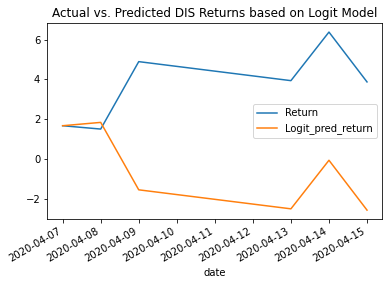

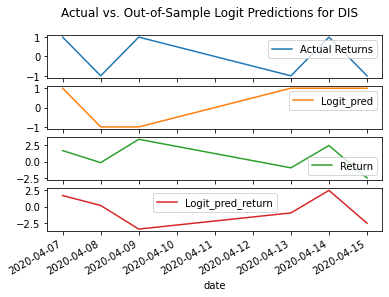

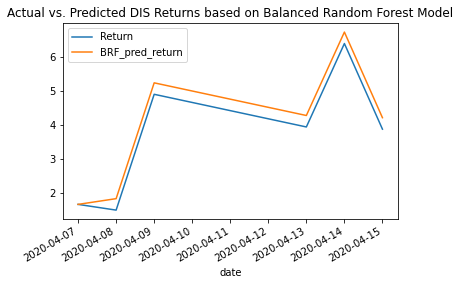

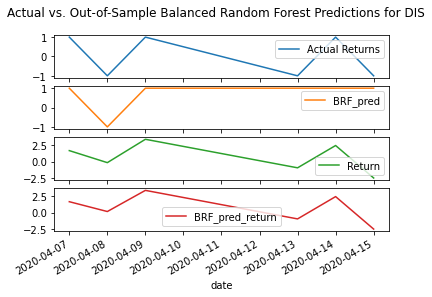

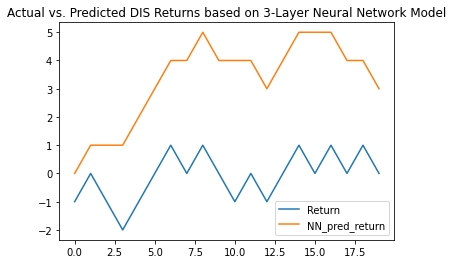

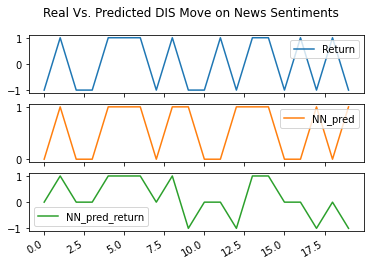

In [21]:
# Create a Title for the Dashboard
title = pn.pane.Markdown(
    """
# Sentimental Stocks? Nailed it!
""",
    width=800,
)

welcome = pn.pane.Markdown(

"""
## Ready for Ocean Breeze?
###_Invest now and get ready for summer!_ 
_Buy low and sell high based on news over the past month_ 
_Get latest recommendation with just ONE CLICK on the buttom_ 
### Conclusion: 
_Investment style varies. Personality shines._ 
#### Models

_**Based on 31 days of data for Disney (DIS): 3/15/2020 to 4/15/2020**_

_**a. Logit Regression**_

* The `balanced accuracy score` is 0.83.


<details><summary>
Code (click me)
</summary>

```python
# ********* MODEL FITTING *************
   # --------- Logit -----------
   # --------Start-------------
   
M = 'Logit'
from sklearn import linear_model 
lm = linear_model.LogisticRegression(C = 1e5)
lm.fit(X_train, y_train)
lm_pred = lm.predict(X_test)


  # --------- Logit ------------
   # ---------End -------------

```

</details>




_**b. Balanced Random Forest Classifier Ensemble Learning**_

* The `balanced accuracy score` is 0.67.
* Better choice over Decision Tree model as it prevents _**overfitting**_


<details><summary>
Code
</summary>

```python

# ***************** MODEL FITTING *****************
   # --------- Balanced Random Forest -----------
   # -------------------Start--------------------

# Resample the training data with the RandomOversampler
# fit Random Forest Classifier
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf.fit(X_train, y_train)
brf_pred = brf.predict(X_test)
# Evaluating the Balanced Random Forest model in a nicer format
# Calculating the confusion matrix
cm_brf = confusion_matrix(y_test, brf_pred)
cm_brf_df = pd.DataFrame(
    cm_brf, index=["Actual -1", "Actual 1"], columns=["Predicted -1", "Predicted 1"]
)
# Calculating the accuracy score
acc_brf_score = accuracy_score(y_test, brf_pred)
# Displaying results
print("Confusion Matrix - Balanced Random Forest")
display(cm_brf_df)
print(f"Accuracy Score : {acc_brf_score:,.04f}")
print("Classification Report - Balaced Random Forest")
print(classification_report(y_test, brf_pred))
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print("Classification Report - Balanced Random Forest on Imbalanced Data")
print(classification_report_imbalanced(y_test, brf_pred))

```
</details>

"""
)

note = pn.pane.Markdown(
'''
* The Logit model is offering a balanced accuracy score of predictions for the test dataset, 
* which is 30% of 20, or 6 predictions. 
* The reason we usually get 50% as the balanced accuracy score is because 
* with so little data (and having been trained on so little data - 14 days), 
* it's basically randomly guessing and getting it right 50% of the time. 
* Now, sometimes we're a value of .25 (25%) or .625 (62.5%)
* and you're probably thinking to yourself, 
* 6 can't be divided by another whole number to return that fraction/percentage. 
* True - but we're not using a straight accuracy score in our model, 
* we're using a balanced accuracy score, which is different. 
* Changes on test statistics based on live data may lead to different choice of models._
'''
)

# Create a tab layout for the dashboard
tabs = pn.Tabs(
    ("Welcome", pn.Column(welcome, parallel_categories_com())),
    ("Logit Predictions", pn.Row(logit(), note)),
    ("Machine Learning", pn.Row(brf(), nn())),
    ("Feelings Matter", pn.Column(parallel_categories_neg(), parallel_categories_pos())),
    ( "Staying Calm",
        pn.Column(parallel_categories_neu()))
    
)

panel = pn.Column(pn.Row(title), tabs, width=900)

Column(width=900)
    [0] Row
        [0] Markdown(str, width=800)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Plotly(Figure)
        [1] Row
            [0] Matplotlib(Figure, tight=True)
            [1] Markdown(str)
        [2] Row
            [0] Matplotlib(Figure, tight=True)
            [1] Str(tuple)
        [3] Column
            [0] Plotly(Figure)
            [1] Plotly(Figure)
        [4] Column
            [0] Plotly(Figure)
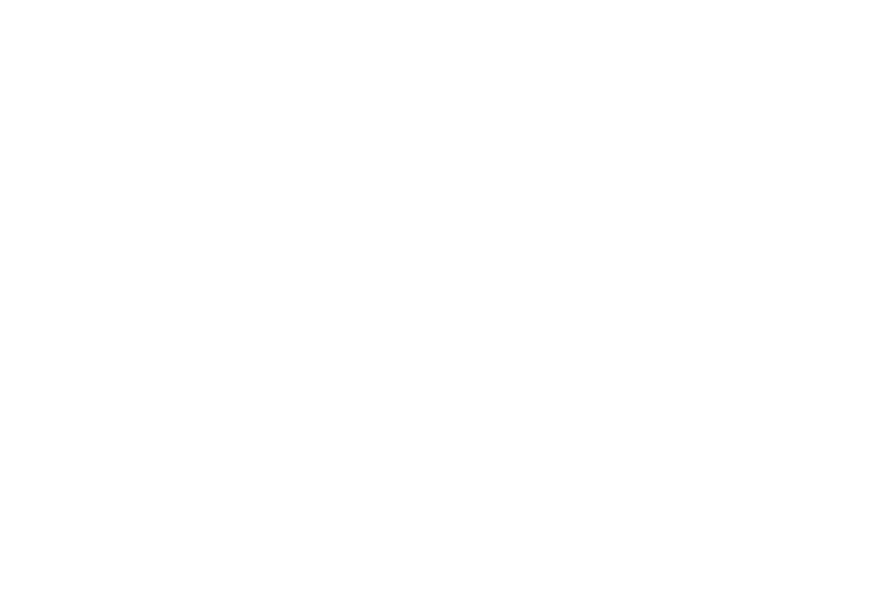
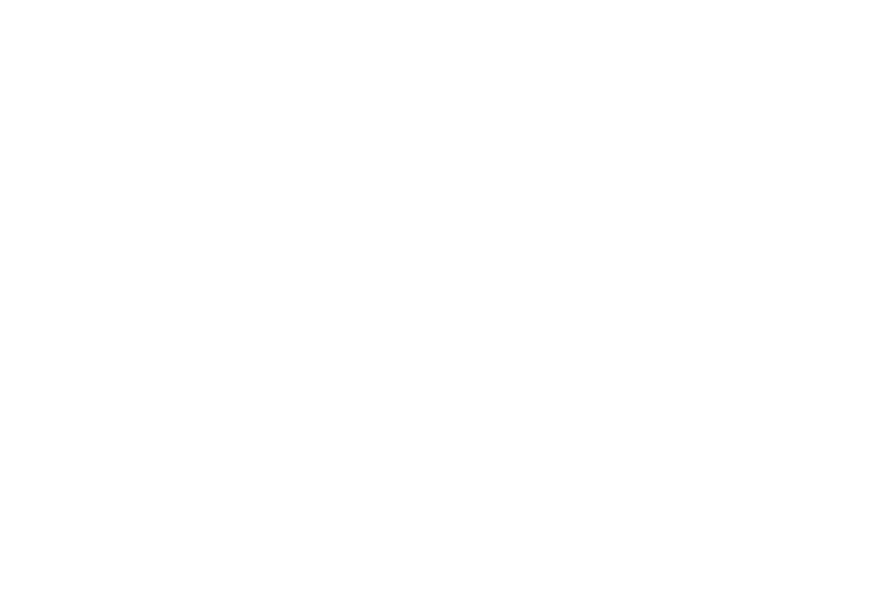

In [22]:
panel.servable()